# **K-Means From Scratch in Python**

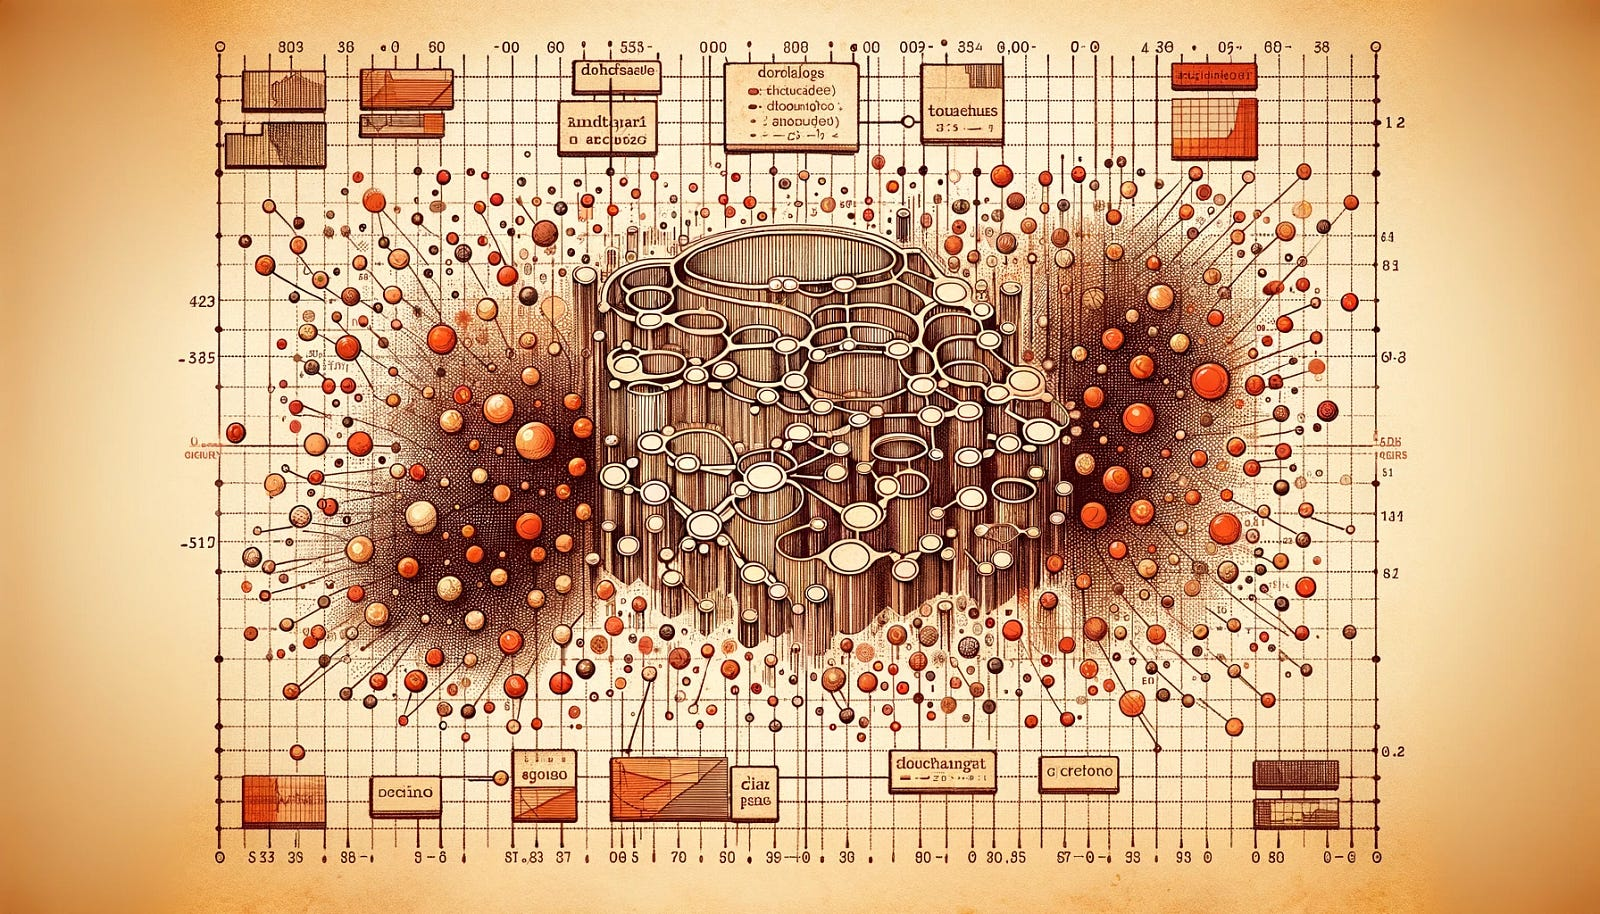

*By Cristian Leo*

*Link Article*: https://medium.com/towards-data-science/the-math-and-code-behind-k-means-clustering-795582423666

## **Import Required Libraries**

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## **K-Means Class**

In [2]:
class KMeans:
    def __init__(self, K, max_iters=100, tol=1e-4):
        """
        Constructor for KMeans class

        Parameters
        ----------
        K : int
            Number of clusters
        max_iters : int, optional
            Maximum number of iterations, by default 100
        tol : float, optional
            Tolerance to declare convergence, by default 1e-4
        """        
        self.K = K
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
        self.labels = None
        self.inertia_ = None

    def initialize_centroids(self, X):
        """
        Initialize centroids

        Parameters
        ----------
        X : array-like
            Input data
        
        Returns
        -------
        array-like
            Initial centroids
        """
        # Simple random initialization, consider k-means++ for improvement
        indices = np.random.permutation(X.shape[0])
        centroids = X[indices[:self.K]]
        return centroids

    def compute_centroids(self, X, labels):
        """
        Compute centroids

        Parameters
        ----------
        X : array-like
            Input data
        labels : array-like
            Cluster labels
        
        Returns
        -------
        array-like
            Updated centroids
        """
        centroids = np.zeros((self.K, X.shape[1]))
        for k in range(self.K):
            if np.any(labels == k):
                centroids[k] = np.mean(X[labels == k], axis=0)
            else:
                centroids[k] = X[np.random.choice(X.shape[0])]
        return centroids

    def compute_distance(self, X, centroids):
        """
        Compute distances between data points and centroids

        Parameters
        ----------
        X : array-like
            Input data
        centroids : array-like
            Centroids
        
        Returns
        -------
        array-like
            Distances
        """
        distances = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            distances[:, k] = np.linalg.norm(X - centroids[k], axis=1) ** 2
        return distances

    def find_closest_cluster(self, distances):
        """
        Find the closest cluster for each data point

        Parameters
        ----------
        distances : array-like
            Distances
        
        Returns
        -------
        array-like
            Cluster labels
        """
        return np.argmin(distances, axis=1)

    def fit(self, X):
        """
        Fit the model

        Parameters
        ----------
        X : array-like
            Input data
        """
        self.centroids = self.initialize_centroids(X)
        for i in range(self.max_iters):
            distances = self.compute_distance(X, self.centroids)
            self.labels = self.find_closest_cluster(distances)
            new_centroids = self.compute_centroids(X, self.labels)
            # Compute inertia (sum of squared distances)
            inertia = np.sum([distances[i, label] for i, label in enumerate(self.labels)])
            # Check for convergence: if the centroids don't change much (within tolerance)
            if np.allclose(self.centroids, new_centroids, atol=self.tol) or inertia <= self.tol:
                break
            self.centroids = new_centroids
        self.inertia_ = inertia

    def predict(self, X):
        """
        Predict the closest cluster for each data point

        Parameters
        ----------
        X : array-like
            Input data
        
        Returns
        -------
        array-like
            Cluster labels
        """
        distances = self.compute_distance(X, self.centroids)
        return self.find_closest_cluster(distances)

## **Generate Synthetic Dataset for Clustering**

In [3]:
# Generate a synthetic dataset
X, y_true = datasets.make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

### **Pairplot Visualization**

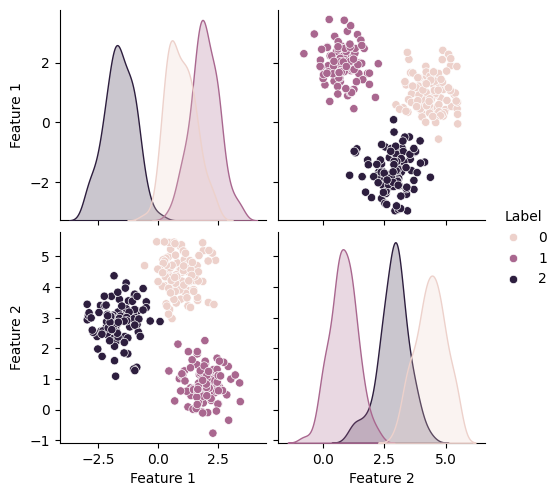

In [4]:
# Create a DataFrame from your data
df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])

# Add the true labels to the DataFrame
df['Label'] = y_true

# Create a pairplot
sns.pairplot(df, hue='Label')
plt.show()

### **Scatterplot Visualization**

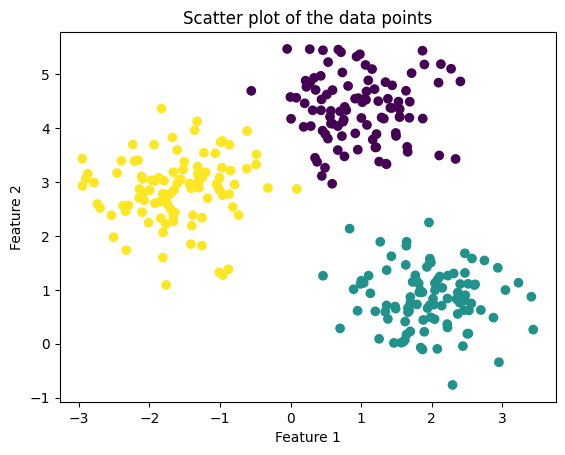

In [5]:
# Scatter plot of the data points
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis')
plt.title('Scatter plot of the data points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### **Normalize Data**

In [6]:
# Normalize the data
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

## **Elbow Plot**

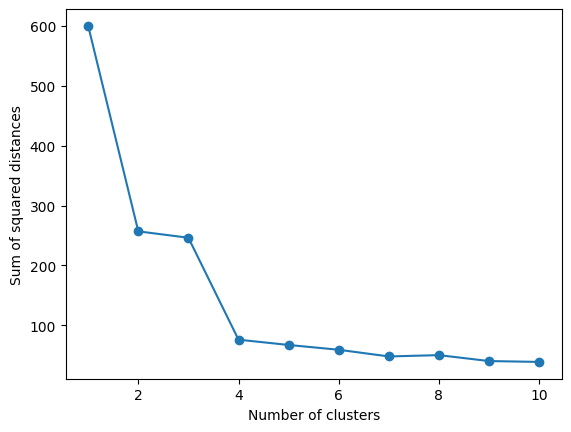

In [7]:
# Calculate the sum of squared distances for K = 1 through K = 10
ssd = []
K_range = range(1, 11)
for K in K_range:
    kmeans = KMeans(K=K, max_iters=300)
    kmeans.fit(X)
    ssd.append(kmeans.inertia_)

# Plot the sum of squared distances
plt.plot(K_range, ssd, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

### **Silhouette Plot**

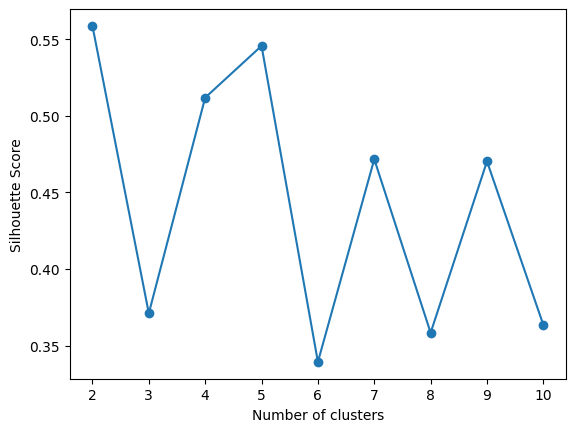

In [8]:
def silhouette_score(X, labels):
    # Step 1: For each point, calculate the average distance to all other points in the same cluster
    a = np.array([np.mean(np.sqrt(np.sum((X[labels == labels[i]] - X[i])**2, axis=1))) for i in range(X.shape[0])])

    # Step 2: For each point, calculate the average distance to all points in the nearest cluster
    b = np.array([min([np.mean(np.sqrt(np.sum((X[labels == k] - X[i])**2, axis=1))) for k in set(labels) if k != labels[i]]) for i in range(X.shape[0])])

    # Step 3: The silhouette score for a point is (b - a) / max(a, b)
    silhouette_scores = (b - a) / np.maximum(a, b)

    # The overall silhouette score is the average of the silhouette scores for all points
    return np.mean(silhouette_scores)

silhouette_scores = []
K_range = range(2, 11)  # Start from 2 because silhouette_score needs at least 2 clusters

for K in K_range:
    kmeans = KMeans(K=K, max_iters=300)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()